Import Libraries

In [86]:
import os
import numpy as np
import pandas as pd

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 24

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Preprocessing, model selection & metrics import
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

Importing data

In [3]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv')


In [4]:
print(f'Train shape: {train_values.shape}')
print(f'Test shape: {test_values.shape}')

Train shape: (260601, 39)
Test shape: (86868, 39)


In [5]:
#display to 5 rows
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


The data contains details about buildings/constructions damaged due to the earthquake occured in a region.

For that we are provided with geographical details, how many floor does the building had, age of construction, height, land surface, materials used for building the construction etc.

Here we have supervised data, the label/target is damage level indicated as value 1, 2, & 3.

This comes under multiclass or multinomial classification where we need to predict one class from more than two classes.

In [6]:
# exploring the statstical fearures of train dataset.
train_values.describe().T.style.background_gradient(cmap='Set2',low =0.4,high=0.1,axis=0)

,count,mean,std,min,25%,50%,75%,max
building_id,260601.000000,525675.482773,304544.999032,4.000000,261190.000000,525757.000000,789762.000000,1052934.000000
geo_level_1_id,260601.000000,13.900353,8.033617,0.000000,7.000000,12.000000,21.000000,30.000000
geo_level_2_id,260601.000000,701.074685,412.710734,0.000000,350.000000,702.000000,1050.000000,1427.000000
geo_level_3_id,260601.000000,6257.876148,3646.369645,0.000000,3073.000000,6270.000000,9412.000000,12567.000000
count_floors_pre_eq,260601.000000,2.129723,0.727665,1.000000,2.000000,2.000000,2.000000,9.000000
age,260601.000000,26.535029,73.565937,0.000000,10.000000,15.000000,30.000000,995.000000
area_percentage,260601.000000,8.018051,4.392231,1.000000,5.000000,7.000000,9.000000,100.000000
height_percentage,260601.000000,5.434365,1.918418,2.000000,4.000000,5.000000,6.000000,32.000000
has_superstructure_adobe_mud,260601.000000,0.088645,0.284231,0.000000,0.000000,0.000000,0.000000,1.000000
has_superstructure_mud_mortar_stone,260601.000000,0.761935,0.425900,0.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# exploring the statstical fearures of train dataset (object).
train_values.describe(include="object").T

,count,unique,top,freq
land_surface_condition,260601,3,t,216757
foundation_type,260601,5,r,219196
roof_type,260601,3,n,182842
ground_floor_type,260601,5,f,209619
other_floor_type,260601,4,q,165282
position,260601,4,s,202090
plan_configuration,260601,10,d,250072
legal_ownership_status,260601,4,v,250939


In [11]:
# checking the types of varibles in the dataset(int,float,object)
dtypes=pd.DataFrame(train_values.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=train_values.nunique()
dtypes["Null Values"]=train_values.isnull().sum()
dtypes["% null Values"]=train_values.isnull().sum()/len(train_values)
dtypes.style.background_gradient(cmap='Set2',axis=0)

,Data Type,Unique Values,Null Values,% null Values
building_id,int64,260601,0,0.000000
geo_level_1_id,int64,31,0,0.000000
geo_level_2_id,int64,1414,0,0.000000
geo_level_3_id,int64,11595,0,0.000000
count_floors_pre_eq,int64,9,0,0.000000
age,int64,42,0,0.000000
area_percentage,int64,84,0,0.000000
height_percentage,int64,27,0,0.000000
land_surface_condition,object,3,0,0.000000
foundation_type,object,5,0,0.000000


Missing values

Data is clean without missing values or nan, so we can proceed further for EDA

In [28]:
#Merge the lable/target column with features
train = pd.merge(train_values, train_labels, on='building_id')

# Exploratory Data Analysis

Damage Grade

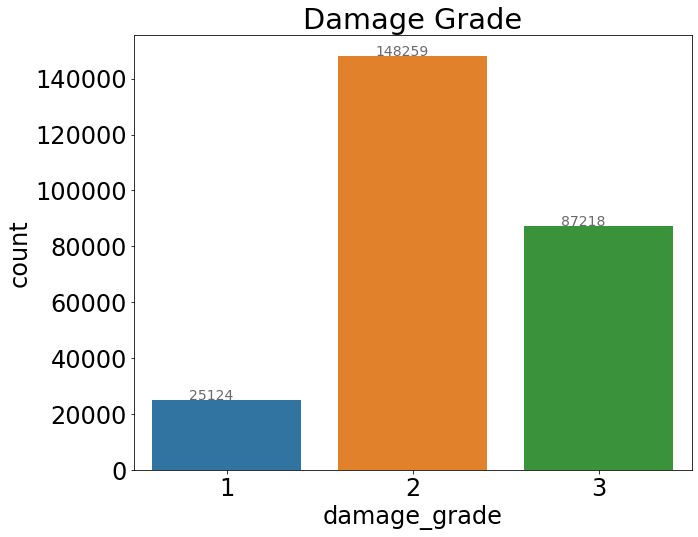

In [29]:
# checking the dependent variable --> `damage_grade`
plt.figure(figsize=(10,8))
ax=sns.countplot("damage_grade",data=train_labels)
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.2, i.get_height()+3, \
            str(round((i.get_height()), 2)), fontsize=14, color='dimgrey')
plt.title("Damage Grade")
plt.show()  



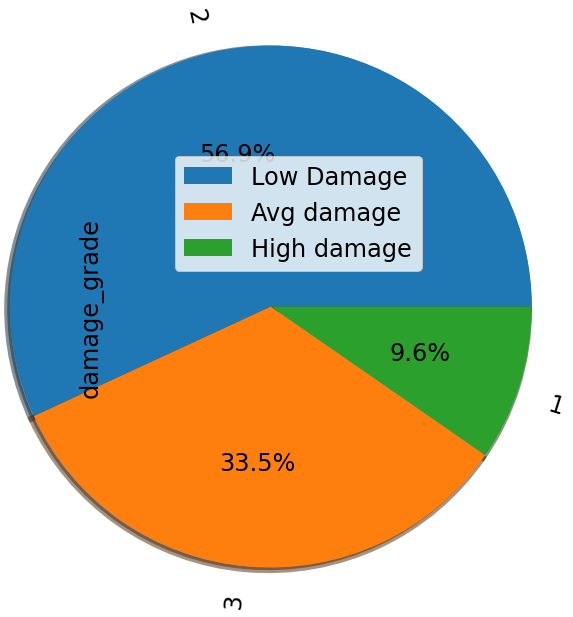

In [30]:
###############################################################
#                       pie plot                              #                                                            
###############################################################
plt.figure(figsize=(10,6))
train_labels["damage_grade"].dropna().astype(int).value_counts().plot.pie(autopct="%.1f%%", 
                                                    shadow=True,rotatelabels=True,
                                                    wedgeprops={'linewidth': 6},
                                                    radius=2
                                                    )
plt.legend(["Low Damage","Avg damage","High damage"])
plt.show()

OBSERVATIONS

Now we will see if the age of the building affect on damage due to earthquake ?

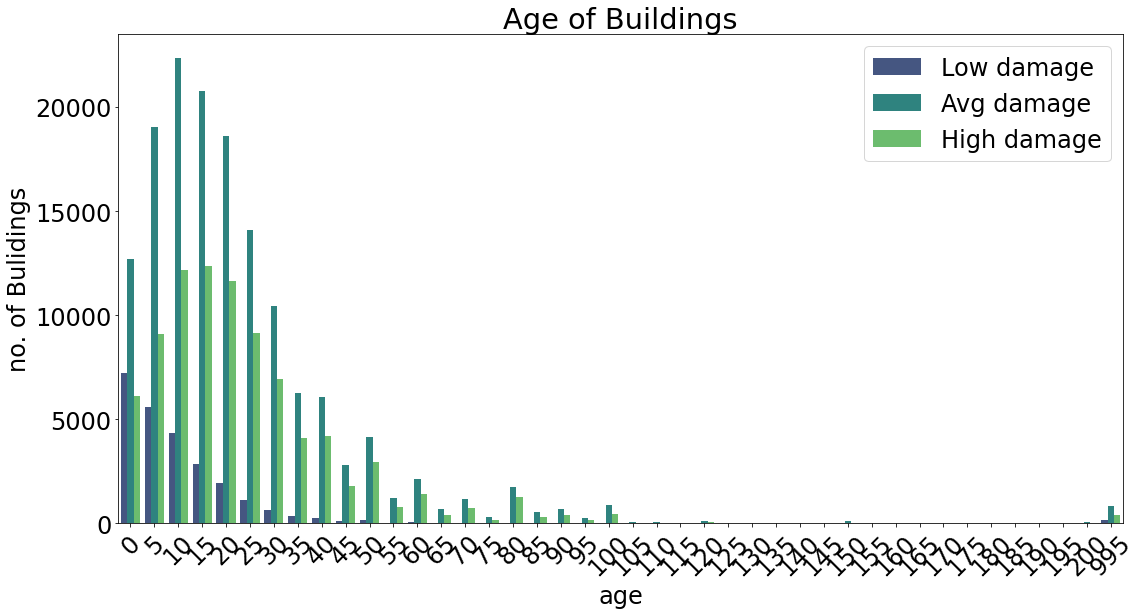

In [38]:
plt.figure(figsize=(18,9))
sns.countplot(x=train_values["age"],hue=train_labels["damage_grade"],palette="viridis")
plt.ylabel("no. of Bulidings")
plt.title("Age of Buildings")
plt.legend(["Low damage","Avg damage","High damage"],loc="upper right")
plt.xticks(rotation=45)
plt.show()

OBSERVATIONS

Does the area of buliding affect on damage caused due to earthquake ?

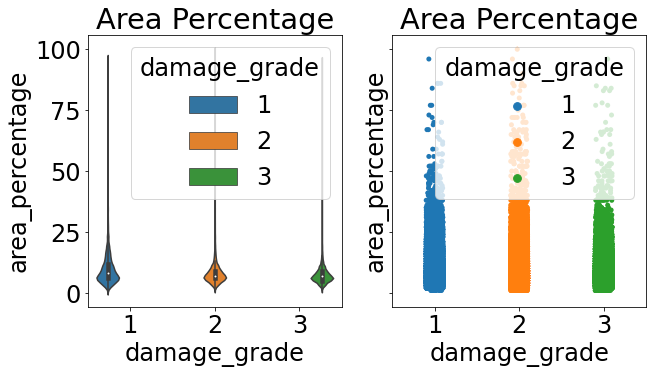

<Figure size 720x648 with 0 Axes>

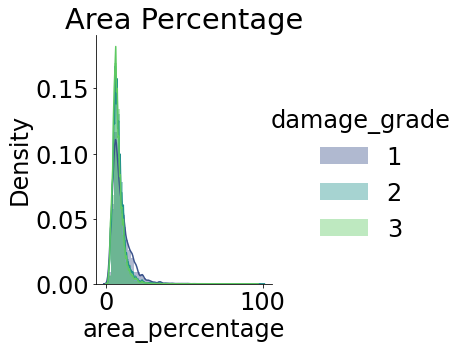

In [47]:
fig,ax=plt.subplots(1,2,figsize=(10,5), sharey=True)
###############################################################
#                      Violin plot                            #
###############################################################

sns.violinplot(data=train,x='damage_grade',y='area_percentage',hue='damage_grade',
                   split=False,ax=ax[0])

sns.stripplot(data=train,x='damage_grade',y='area_percentage',hue='damage_grade',jitter=True,ax=ax[1])
#plt.ylabel("Company Status",**font)
ax[0].set_title("Area Percentage")
ax[1].set_title("Area Percentage")
plt.show()
###############################################################
#                       Facet Grid                            #
###############################################################

plt.figure(figsize=(10,9))
sns.FacetGrid(train,hue='damage_grade',height=5,palette="viridis")\
    .map(sns.distplot,'area_percentage')\
    .add_legend()
plt.title("Area Percentage")
plt.show()

OBSERVATIONS

The above plots infers that as the area of the buliding increases the damaged caused to it also increases.

# Does the height of buliding affect on damage caused due to earthquake ?

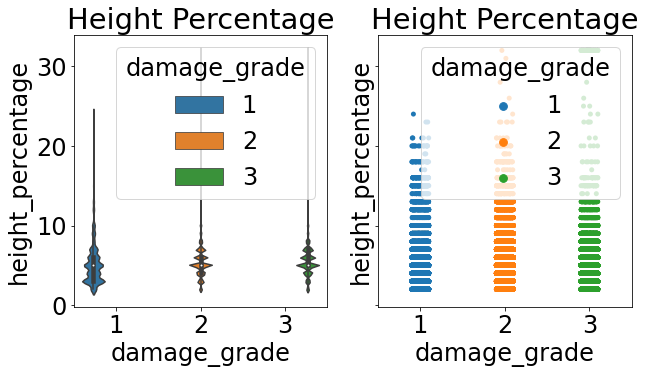

<Figure size 720x360 with 0 Axes>

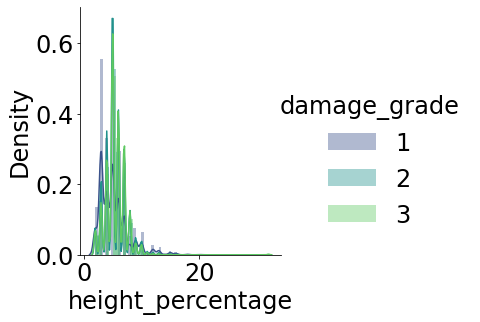

In [48]:
fig,ax=plt.subplots(1,2,figsize=(10,5), sharey=True)
###############################################################
#                      Violin plot                            #
###############################################################

sns.violinplot(data=train,x='damage_grade',y='height_percentage',hue='damage_grade',
                   split=False,ax=ax[0])

sns.stripplot(data=train,x='damage_grade',y='height_percentage',hue='damage_grade',jitter=True,ax=ax[1])
#plt.ylabel("Company Status",**font)
ax[0].set_title("Height Percentage")
ax[1].set_title("Height Percentage")
plt.show()
###############################################################
#                       Facet Grid                            #
###############################################################

plt.figure(figsize=(10,5))
sns.FacetGrid(train,hue='damage_grade',height=5,palette="viridis")\
    .map(sns.distplot,'height_percentage')\
    .add_legend()
plt.show()


OBSERVATIONS

The above plots infers that as the height of the buliding increases the damaged caused to it also increases.

# Do number of floors in the buliding affect on damage caused due to earthquake ?

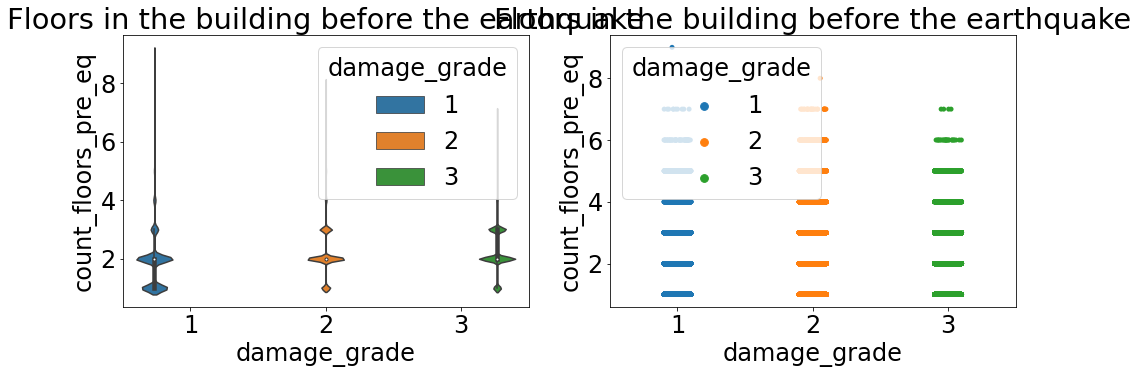

<Figure size 720x360 with 0 Axes>

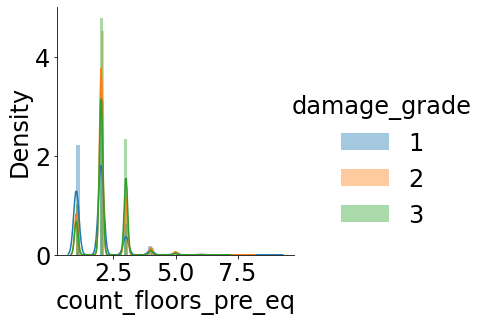

In [50]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
###############################################################
#                      Violin plot                            #
###############################################################

sns.violinplot(data=train,x='damage_grade',y='count_floors_pre_eq',hue='damage_grade',
                   split=False,ax=ax[0])

sns.stripplot(data=train,x='damage_grade',y='count_floors_pre_eq',hue='damage_grade',jitter=True,ax=ax[1])
#plt.ylabel("Company Status",**font)
ax[0].set_title("Floors in the building before the earthquake")
ax[1].set_title("Floors in the building before the earthquake")
plt.show()
###############################################################
#                       Facet Grid                            #
###############################################################
plt.figure(figsize=(10,5))
sns.FacetGrid(train,hue='damage_grade',height=5)\
    .map(sns.distplot,'count_floors_pre_eq')\
    .add_legend()
plt.show()

# Families affected due to earthquake ?

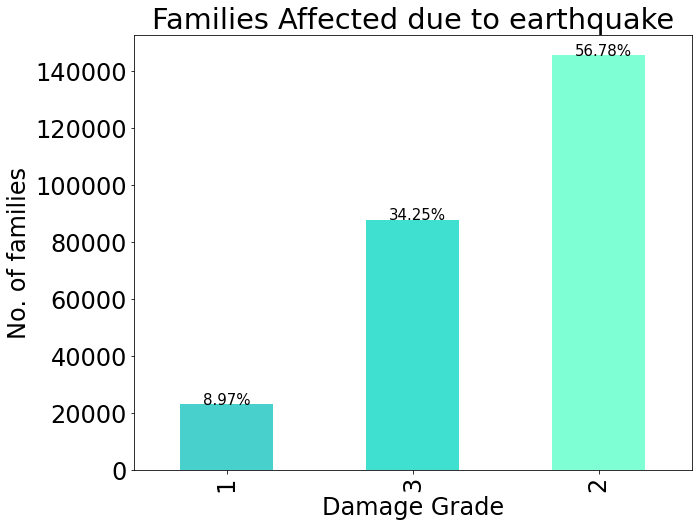

In [51]:
plt.figure(figsize=(10,8))
ax=train.groupby("damage_grade")["count_families"].sum().sort_values().plot.bar(color=["mediumturquoise","turquoise","aquamarine"],
                                                                               )
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()+5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='black')
plt.title("Families Affected due to earthquake")
plt.ylabel("No. of families")
plt.xlabel("Damage Grade")
plt.show()


OBSERVATIONS

34.25% of the families lived in houses which were prone to high damage. Therefore, making them the most exposed group in the population to Critical Health and Financial Damages.
56.78% of the families lived in decent houses but were affected the most in the entire population.
8.97% of the families lived in well built houses which were able to withstand the earthquake.

Density plot on continuous value features

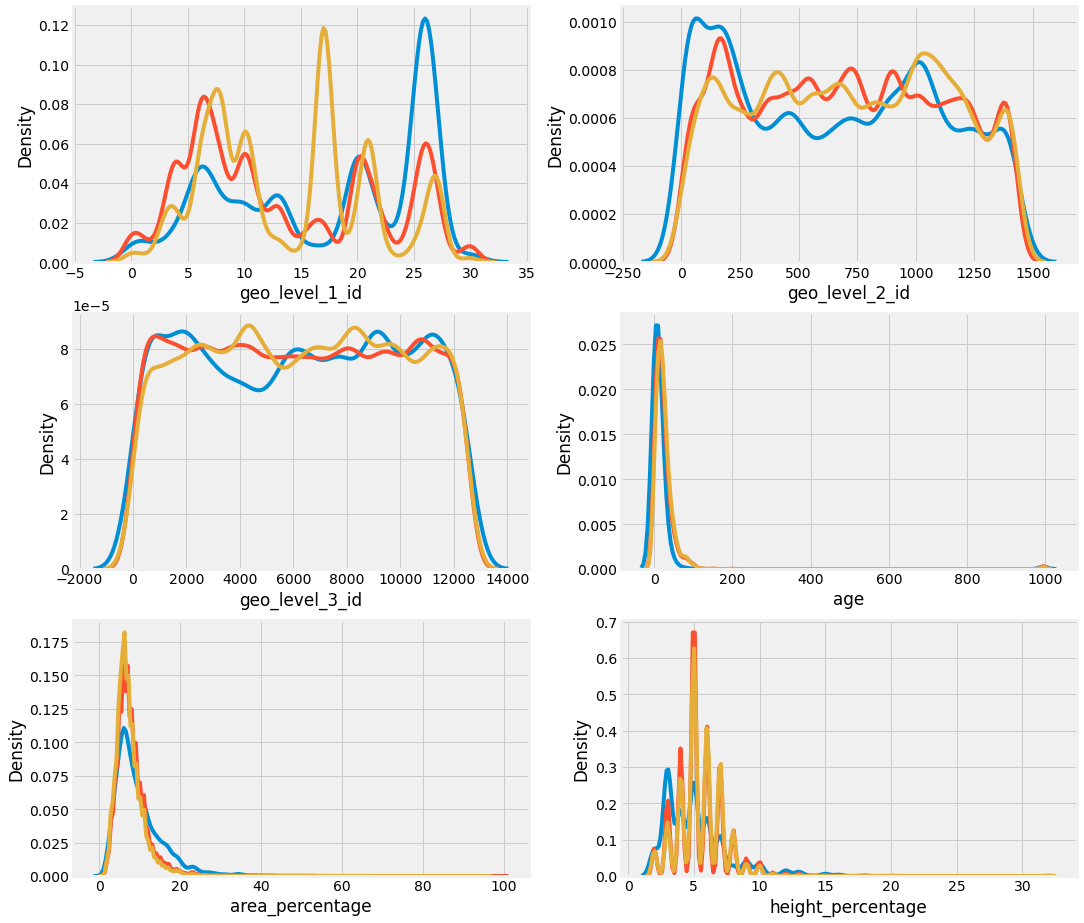

In [52]:
#continuous values
cont_values = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','age','area_percentage','height_percentage']

def densityPlot(cont_values):
  fig = plt.figure(figsize=(18,16))
  plt.style.use('fivethirtyeight')
  for i,txt in enumerate(cont_values):
    ax = fig.add_subplot(3,2,i+1)
    sns.kdeplot(train.loc[train['damage_grade'] == 1, txt], ax=ax, label='damage_grade==1')
    sns.kdeplot(train.loc[train['damage_grade'] == 2, txt], ax=ax, label='damage_grade==2')
    sns.kdeplot(train.loc[train['damage_grade'] == 3, txt], ax=ax, label='damage_grade==3')
  plt.show()
densityPlot(cont_values)

From plotting continuous feature values using kdeplot (kernel density plot), we can see there is few changes in pattern on columns geo_level_1_id,geo_level_2_id which will help us for better prediction

# Analyse Categorical Features with respect to Damage Grade ?

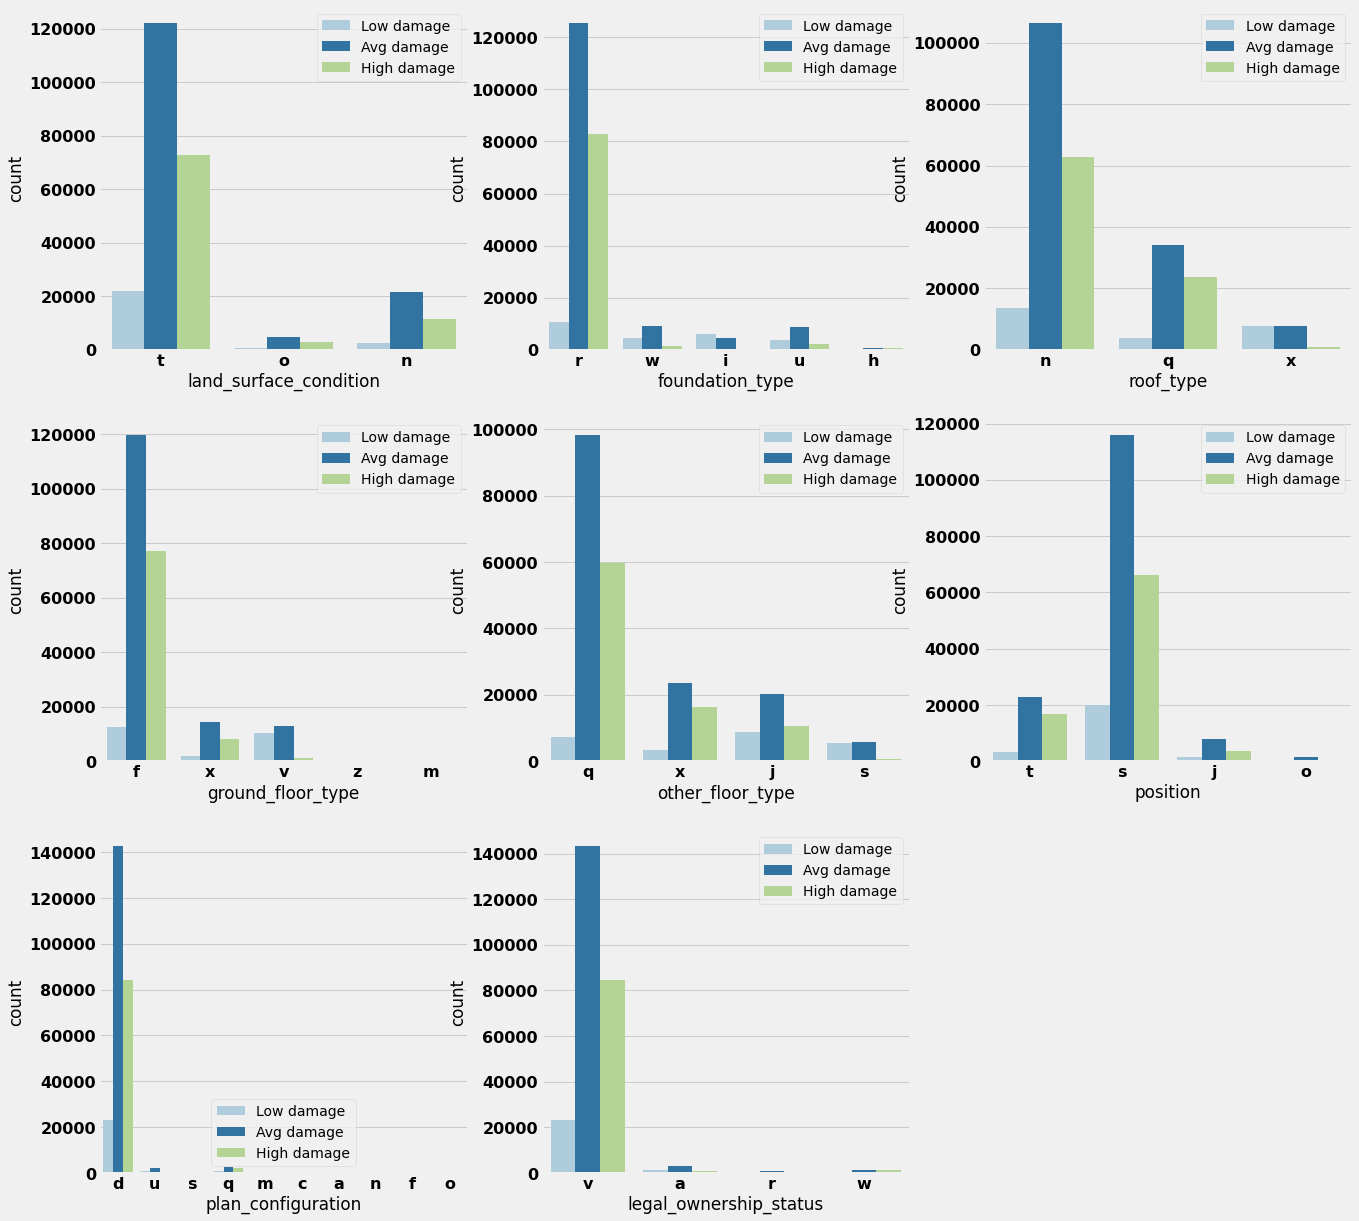

In [53]:
cat_cols=train.select_dtypes(include="object")
font={'weight' : 'bold',
        'size': 16}       
q=1
plt.figure(figsize=(20,20))
for j in cat_cols:
    plt.subplot(3,3,q)
    ax=sns.countplot(train[j].dropna(),palette="Paired",hue=train["damage_grade"])
    plt.xticks(**font)
    plt.yticks(**font)
    plt.xlabel(j)
    plt.legend(["Low damage","Avg damage","High damage"])
    q+=1
plt.show()

# Count plot on binary features

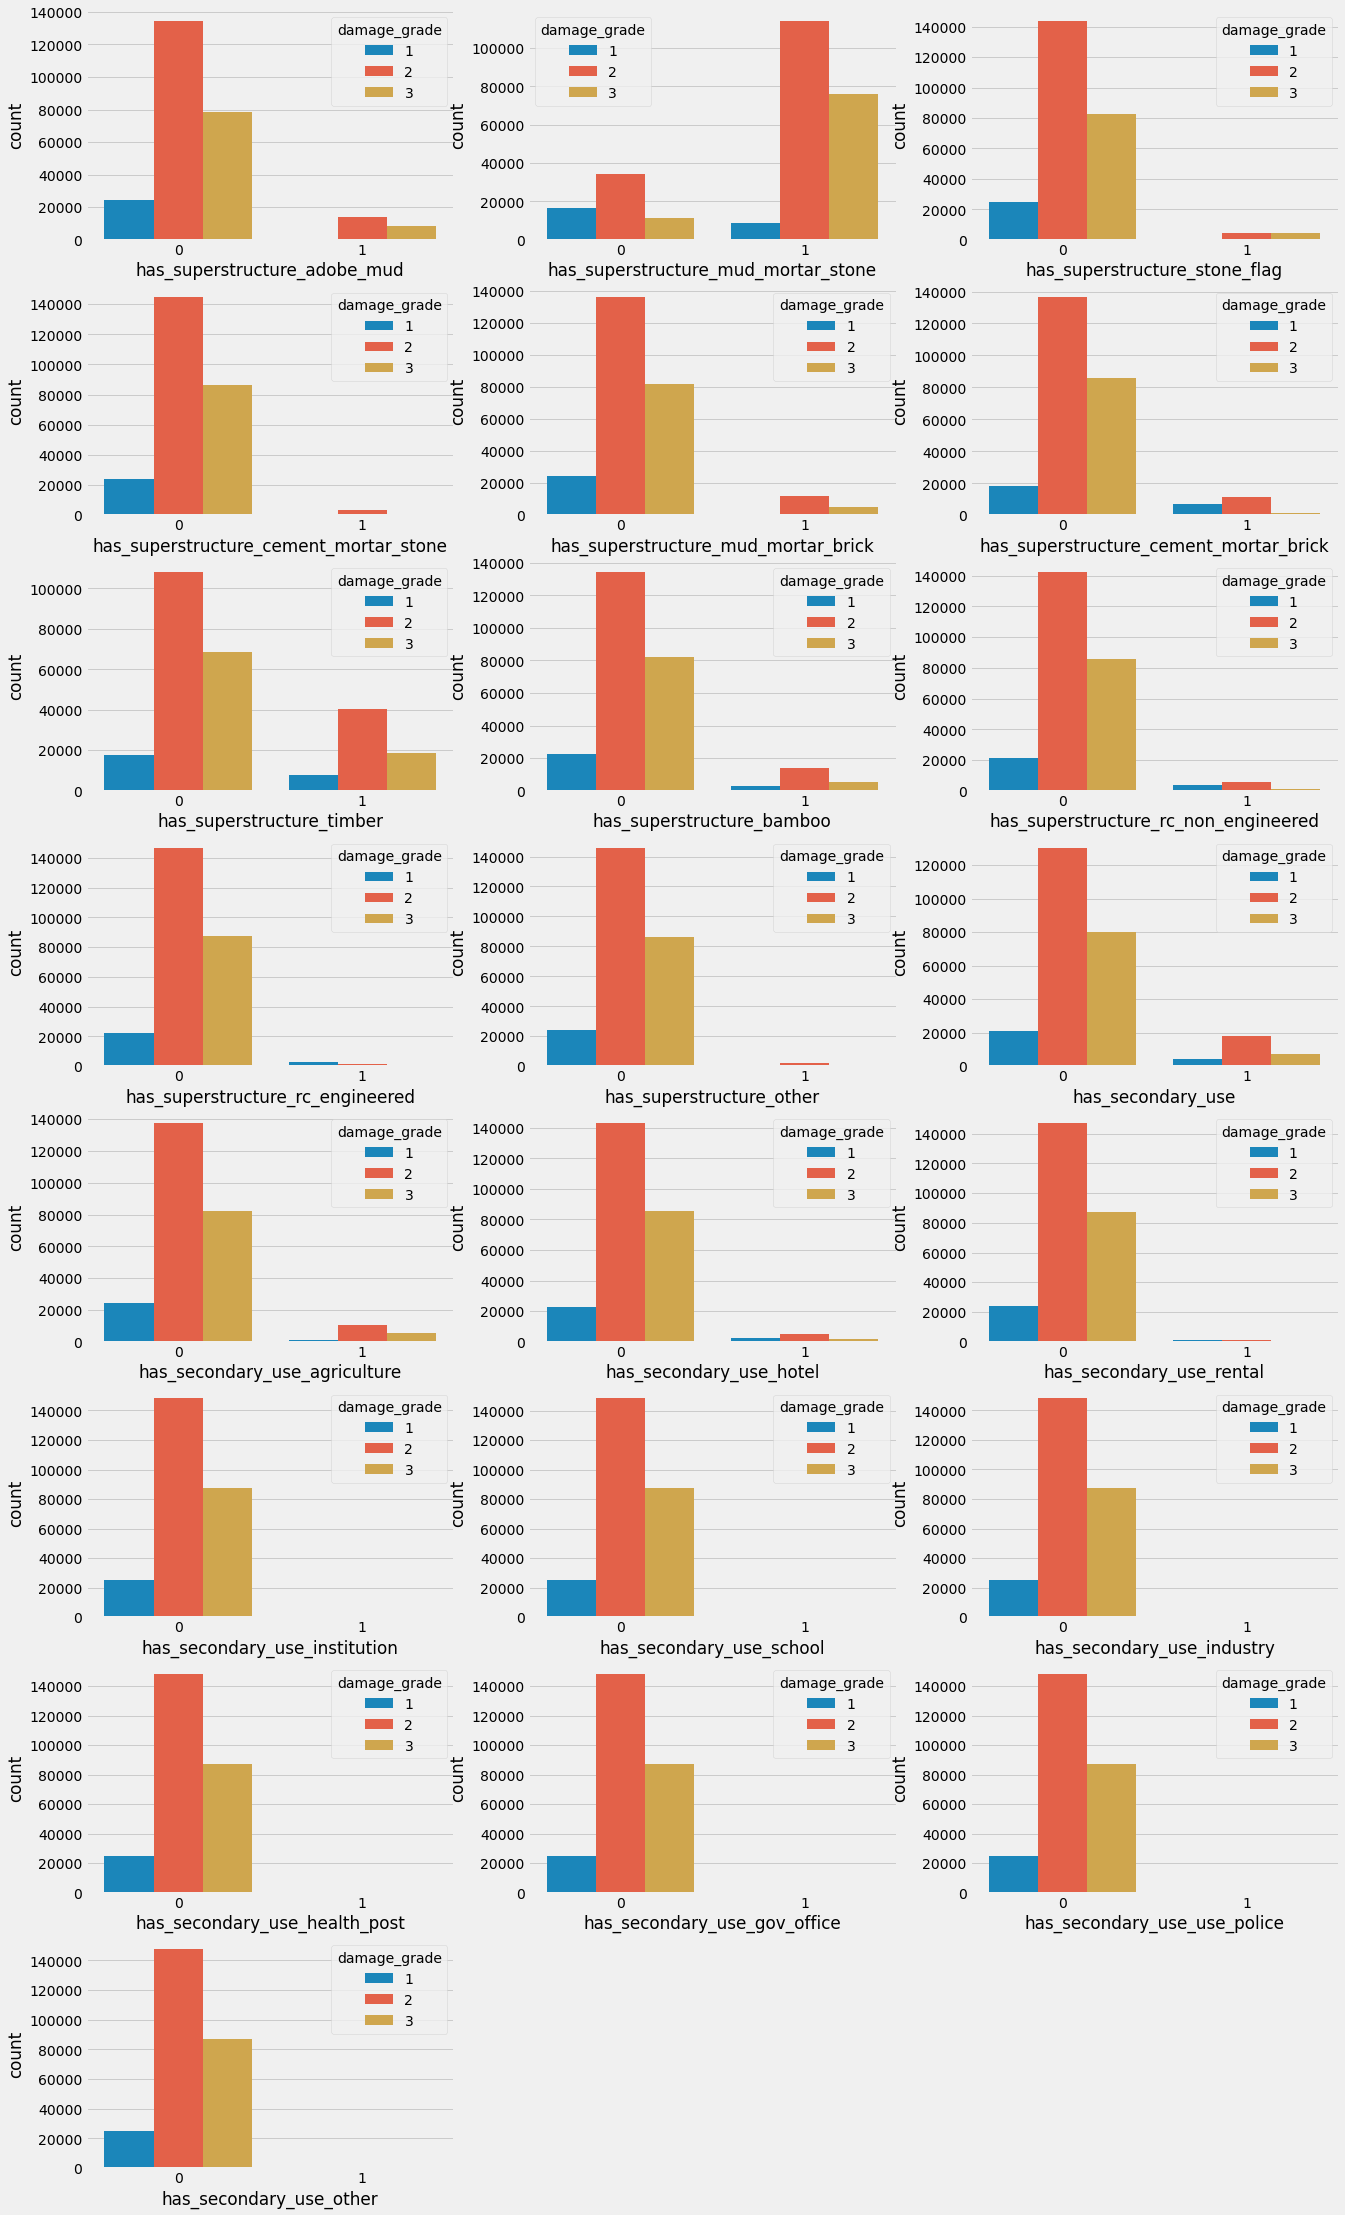

In [54]:
#Binary columns are selected using the column name having word 'has'
bin_cols = train.columns[train.columns.str.startswith('has')]

def countPlot(bin_cols):
  plt.rcParams['font.size'] = 18
  plt.style.use('fivethirtyeight')
  fig = plt.figure(figsize=(20,37))
  for i,txt in enumerate(bin_cols):
    ax = fig.add_subplot(8,3,i+1)
    sns.countplot(x=train[txt], ax=ax, hue=train['damage_grade'])
  plt.show()
countPlot(bin_cols)


# Correlation of independent variables with dependant variable ?

<AxesSubplot:>

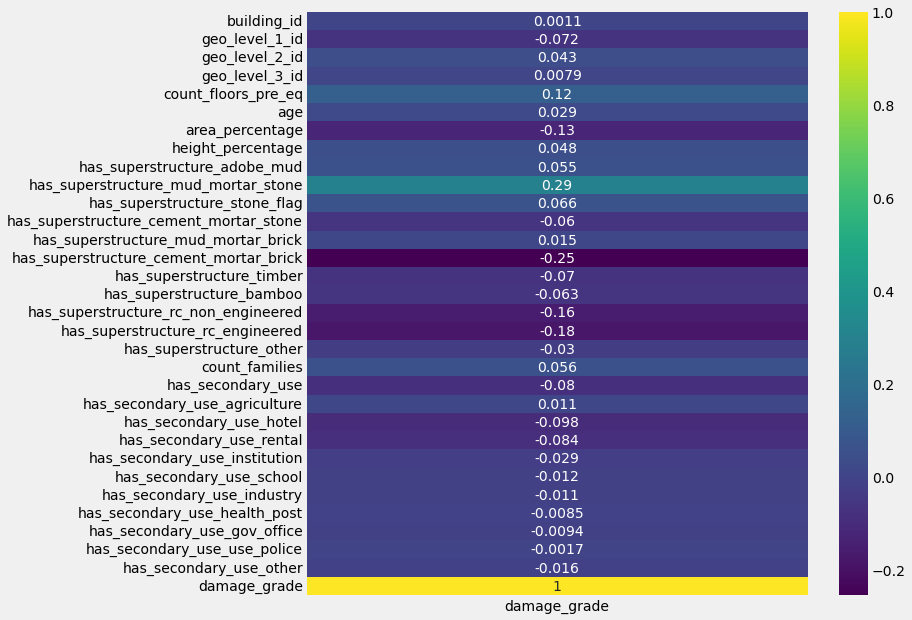

In [55]:
plt.figure(figsize=(10,10))
cor=train.corr()["damage_grade"]
cor=pd.DataFrame(cor)
sns.heatmap(cor,annot=True,cmap="viridis")

# Do we have any outliers in the dataset ?

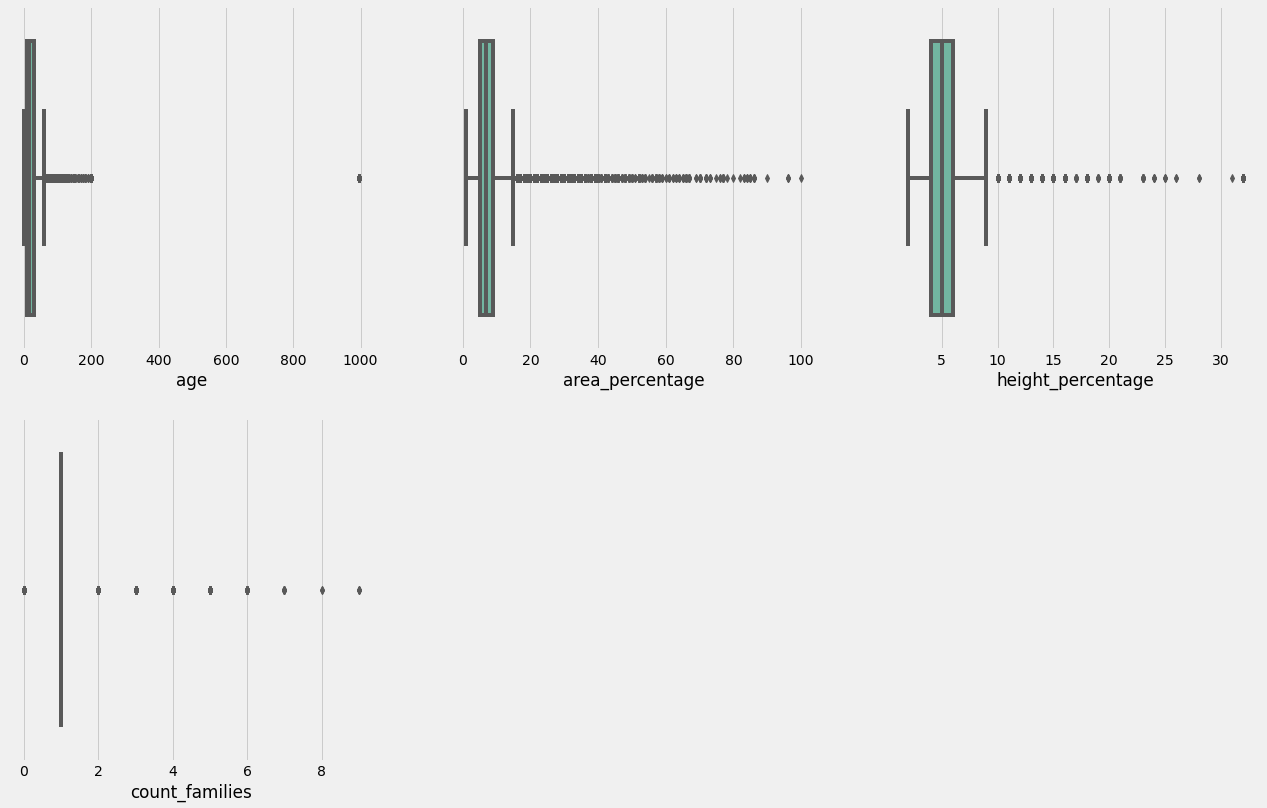

In [56]:
boxplot_cols=["age","area_percentage","height_percentage","count_families"]
q=1
plt.figure(figsize=(20,20))
for j in boxplot_cols:
    plt.subplot(3,3,q)
    ax=sns.boxplot(train[j].dropna(),palette="Set2")
    plt.xlabel(j)
    q+=1
plt.show()

OBSERVATION

boxplots infer that the data consists of many outliers.

# Feature engineering

As a first step we need to concat both train & test data to do feature engineering on both the data.

In [57]:
df_full = pd.concat([train, test_values], axis=0).reset_index(drop=True)
df_full.shape

(347469, 40)

Function to merge new columns generated through feature engineering

In [58]:
def merge_by_concat(df1, df2, merge_on):
  merged_gf = df1[merge_on]
  merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
  new_columns = [col for col in list(merged_gf) if col not in merge_on]
  df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
  return df1

Now let us create new columns by grouping geographical columns.

Creating mean age,height_percentage,area_percentage from grouping geographic level columns geo_level_1_id,geo_level_2_id,geo_level_3_id

In [59]:
geo_age_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['age'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_age_mean'})
geo_height_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['height_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_height_mean'})
geo_area_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['area_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_area_mean'})

Now let us create new columns by grouping different types of roof columns

Creating mean age,height_percentage,area_percentage from grouping roof & foundation columns foundation_type,roof_type,ground_floor_type,`other_floor_type'


In [60]:
type_age_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['age'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_age_mean'})
type_height_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['height_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_height_mean'})
type_area_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['area_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_area_mean'})

In [61]:
#Merge the newly created columns
df_full = merge_by_concat(df_full, geo_age_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
df_full = merge_by_concat(df_full, geo_height_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
df_full = merge_by_concat(df_full, geo_area_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])

df_full = merge_by_concat(df_full, type_age_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])
df_full = merge_by_concat(df_full, type_height_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])
df_full = merge_by_concat(df_full, type_area_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])

Let us check whether binary columns having only single values, because they will not help for model creation

In [62]:
colname=[]
val=[]
bin_cols = df_full.columns[df_full.columns.str.contains('has')]
for bcol in bin_cols:
  colname.append(bcol)
  val.append(df_full[bcol].value_counts().sort_index().values)
pd.DataFrame(val, index=colname)

,0,1
has_superstructure_adobe_mud,316554,30915
has_superstructure_mud_mortar_stone,82671,264798
has_superstructure_stone_flag,335528,11941
has_superstructure_cement_mortar_stone,341104,6365
has_superstructure_mud_mortar_brick,323848,23621
has_superstructure_cement_mortar_brick,321440,26029
has_superstructure_timber,258995,88474
has_superstructure_bamboo,318046,29423
has_superstructure_rc_non_engineered,332678,14791
has_superstructure_rc_engineered,341964,5505


Our assumption is wrong there is no column with single values, all binary column having both 0 & 1.

Now let us create new column with frequency encoding technique for categorical columns as a process in feature engineering

In [64]:
freq_cols = ['land_surface_condition','foundation_type','roof_type',
             'ground_floor_type','other_floor_type','position','plan_configuration',
             'legal_ownership_status']

def frequency_encode(cols, df, self_encoding=False):
  for c in cols:
    fq_dict = df[c].value_counts().to_dict()
    if self_encoding:
      df[c] = df[c].map(fq_dict)
    else:
      df[c+'fq_enc'] = df[c].map(fq_dict)
  return df
df_full_freq = frequency_encode(freq_cols, df_full, self_encoding=True)

We have finished feature engineering, as a next step we may split the train & test data for further process

In [65]:
train_new = df_full_freq[:train_values.shape[0]]
test_new = df_full_freq[train_values.shape[0]:]

As a final step we need to check whether columns in our training data have any collinearity between them

In [66]:
corr_matrix = train_new.drop(columns=['building_id','damage_grade'], axis=1).corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
print('Number of columns having collinearity with other columns other than target: ', len(to_drop))

Number of columns having collinearity with other columns other than target:  0


Number of columns having collinearity with other columns other than target:  0

# Scaling Data

We will scale all columns to avoid unwanted weightage for columns based on different range of numeric values like binary columns will have only 0 & 1, but geographic column having numeric values > 4 digits.

In [67]:
scaler = StandardScaler()

features = train_new.drop(columns=['building_id','damage_grade'], axis=1).columns

X = train_new.drop(columns=['building_id','damage_grade'], axis=1)
test_new = test_new.drop(columns=['building_id','damage_grade'], axis=1)

y = train_new['damage_grade']

sc = scaler.fit(X)
temp_train_X = sc.transform(X)
test_scaled = sc.transform(test_new)

X = pd.DataFrame(temp_train_X, columns=features)
test = pd.DataFrame(test_scaled, columns=features)

# Model Creation

Function to check f1 score of model

In [68]:
def check_model_f1_score(model):
  model.fit(X_train, y_train)
  test_y_pred = model.predict(X_test)
  return f1_score(y_test, test_y_pred, average='micro')

Spliting train data as 75% as train & remaining as test data for validating our model.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Let us create a base prediction, by guessing damage grade value. Here we may do value_counts and select the grade with most value counts as the guessing damage grade prediction value. Using that value let us check base prediction to check our trained model score need to cross more than the base model.

In [71]:
grade_guess = y_test.value_counts().index[0]
base_prediction = np.full(np.shape(y_test), grade_guess)
print('F1 score of base prediction with guess value: ',f1_score(y_test, base_prediction, average='micro'))

F1 score of base prediction with guess value:  0.5680919916603778


In [72]:
lr = LogisticRegression(multi_class='multinomial')
lr_score = check_model_f1_score(lr)
print('Basic LOGISTIC REGRESSION model with default params: ', lr_score)


Basic LOGISTIC REGRESSION model with default params:  0.5914096775431371


Out initial logistic model have crossed the base model score, so we can proceed further to try different types of model like ensemble for better score.

In [73]:
dc = DecisionTreeClassifier()
dc_score = check_model_f1_score(dc)
print('DECISION CLASSIFIER model with default params: ', dc_score)


DECISION CLASSIFIER model with default params:  0.662820889986058


In [74]:
rc = RandomForestClassifier()
rc_score = check_model_f1_score(rc)
print('Basic RANDOM FOREST model with default params: ', rc_score)

Basic RANDOM FOREST model with default params:  0.723577339762858


In [75]:
knc = KNeighborsClassifier()
knc_score = check_model_f1_score(knc)
print('KNEIGHBORS model with default params: ', knc_score)


KNEIGHBORS model with default params:  0.6591499213363861


In [76]:
xg = xgb.XGBClassifier()
xg_score = check_model_f1_score(xg)
print('XGB model with default params: ', xg_score)

[13:40:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB model with default params:  0.7335158158631893


<Figure size 576x432 with 0 Axes>

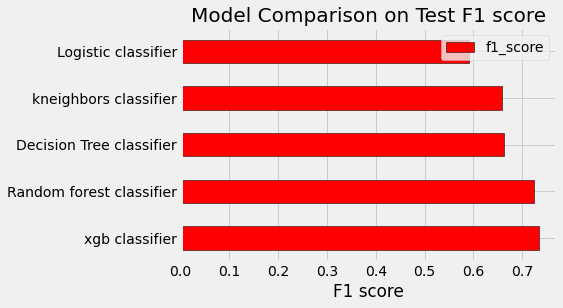

In [77]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
model_comparison = pd.DataFrame({'model':['Logistic classifier','Decision Tree classifier',
                       'Random forest classifier', 'kneighbors classifier',
                       'xgb classifier'], 'f1_score':[lr_score,dc_score,rc_score,
                                                      knc_score,xg_score]})

# Horizontal bar chart of test mae
model_comparison.sort_values('f1_score', ascending = False).plot(x = 'model', y = 'f1_score', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('F1 score'); plt.xticks(size = 14)
plt.title('Model Comparison on Test F1 score', size = 20);

On seeing the model comparison plot, it is clear that Random foreset classsifier out performs than other models, so let us proceed to fine tune hyper parameter of the model further for analysis.

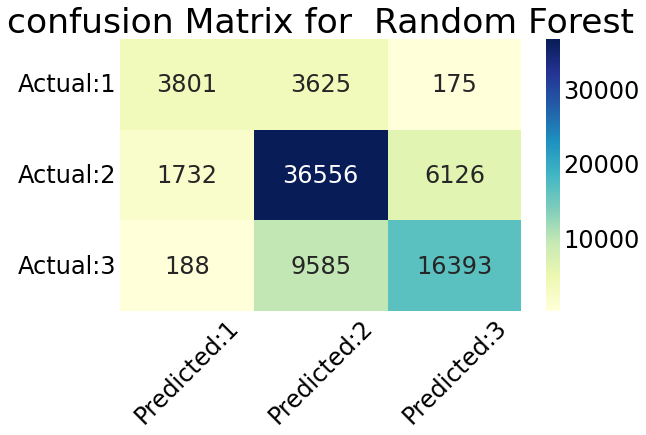

In [84]:
rf = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
cm=confusion_matrix(y_test,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])
                                                                            
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

In [87]:
print("-"*100)
print("Accuracy Score for Random Forest :",accuracy_score(y_test,rf_pred))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_test, rf_pred))
print("-"*100)

----------------------------------------------------------------------------------------------------
Accuracy Score for Random Forest : 0.7258796894386104
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

         1.0       0.66      0.50      0.57      7601
         2.0       0.73      0.82      0.78     44414
         3.0       0.72      0.63      0.67     26166

    accuracy                           0.73     78181
   macro avg       0.71      0.65      0.67     78181
weighted avg       0.72      0.73      0.72     78181

----------------------------------------------------------------------------------------------------


Fine tuned params for Random forest not improved, so let us use other model for prediction.

In [78]:
clf = xgb.XGBClassifier(
    n_estimators=2000,
    objective='multi:softmax',
    num_class=3,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='mlogloss',
    nthread=4,
    tree_method='hist'     
    )

In [79]:
clf.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=50, early_stopping_rounds=100)

[0]	validation_0-mlogloss:1.08894
[50]	validation_0-mlogloss:0.81499
[100]	validation_0-mlogloss:0.70839
[150]	validation_0-mlogloss:0.65418
[200]	validation_0-mlogloss:0.62562
[250]	validation_0-mlogloss:0.60771
[300]	validation_0-mlogloss:0.59590
[350]	validation_0-mlogloss:0.58746
[400]	validation_0-mlogloss:0.58128
[450]	validation_0-mlogloss:0.57705
[500]	validation_0-mlogloss:0.57381
[550]	validation_0-mlogloss:0.57124
[600]	validation_0-mlogloss:0.56951
[650]	validation_0-mlogloss:0.56812
[700]	validation_0-mlogloss:0.56696
[750]	validation_0-mlogloss:0.56611
[800]	validation_0-mlogloss:0.56527
[850]	validation_0-mlogloss:0.56476
[900]	validation_0-mlogloss:0.56446
[950]	validation_0-mlogloss:0.56432
[1000]	validation_0-mlogloss:0.56420
[1050]	validation_0-mlogloss:0.56434
[1097]	validation_0-mlogloss:0.56441


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, monotone_constraints='()',
              n_estimators=2000, n_jobs=4, nthread=4, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.8, tree_method='hist', ...)

In [80]:
xgb_score = check_model_f1_score(clf)
print('XGB score with tuned params: ', xgb_score)


XGB score with tuned params:  0.7461147849221678


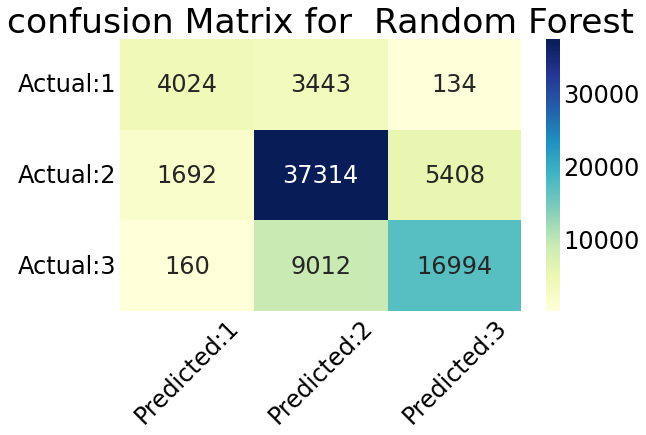

In [94]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, monotone_constraints='()',
              n_estimators=2000, n_jobs=4, nthread=4, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.8, tree_method='hist')
clf.fit(X_train,y_train)
clf_pred=clf.predict(X_test)
cm=confusion_matrix(y_test,clf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])
                                                                            
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

In [95]:
print("-"*100)
print("Accuracy Score for Random Forest :",accuracy_score(y_test,clf_pred))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_test, clf_pred))
print("-"*100)

----------------------------------------------------------------------------------------------------
Accuracy Score for Random Forest : 0.7461147849221678
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

         1.0       0.68      0.53      0.60      7601
         2.0       0.75      0.84      0.79     44414
         3.0       0.75      0.65      0.70     26166

    accuracy                           0.75     78181
   macro avg       0.73      0.67      0.70     78181
weighted avg       0.74      0.75      0.74     78181

----------------------------------------------------------------------------------------------------


In [144]:
# now predicting on test dataset
test=test
clf_pred_test=clf.predict(test)

In [147]:
submission=pd.read_csv("submission_format.csv")
submission=submission.drop("damage_grade",axis=1)
clf_pred_test=pd.DataFrame(clf_pred_test)
submission["damage_grade"]=clf_pred_test
submission.head()

,building_id,damage_grade
0,300051,3.0
1,99355,2.0
2,890251,2.0
3,745817,2.0
4,421793,2.0
